### 用来预测新增量，特征改变，删除movieID之外，加上一些“XX新增”特征

### 1.读取数据；加字段名；查看数据形状：827565行 x 31列

In [7]:
import pandas as pd
import numpy as np
import calendar
import datetime
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
import requests

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['font.serif'] = ['Microsoft YaHei']

In [127]:
original_df = pd.read_csv("./data/filter_time_data.txt", sep='\t\t', header=None)

/home/wujiaocan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [128]:
original_df.columns = [ '电影ID','时间', '当前热度值', '新增热度值','当前点击量','新增点击量','当前评论数','新增评论数','当前点赞数','新增点赞数',
            '当前踩数','新增踩数','当前评分数','推广位','影片推广位等级','当前小时弹幕数','当前小时新增弹幕数','当前小时评分人数',
            '当前小时新增评分人数','当前小时五星评分人数','当前小时四星评分人数','当前小时三星评分人数','当前小时二星评分人数',
            '当前小时一星评分人数','当日爱奇艺播放指数','影片上线时间','导演','编剧','制片','美术','主演']

In [68]:
original_df.columns

Index(['电影ID', '时间', '当前热度值', '新增热度值', '当前点击量', '新增点击量', '当前评论数', '新增评论数',
       '当前点赞数', '新增点赞数', '当前踩数', '新增踩数', '当前评分数', '推广位', '影片推广位等级', '当前小时弹幕数',
       '当前小时新增弹幕数', '当前小时评分人数', '当前小时新增评分人数', '当前小时五星评分人数', '当前小时四星评分人数',
       '当前小时三星评分人数', '当前小时二星评分人数', '当前小时一星评分人数', '当日爱奇艺播放指数', '影片上线时间', '导演',
       '编剧', '制片', '美术', '主演'],
      dtype='object')

In [70]:
def get_time_interval(x, y):
    '''
        获取影片已经上映多久；x:现在时间； y:影片上映时间；
    '''
    from dateutil.parser import parse
    a = parse(x)
    b = parse(y)
    return (a - b).total_seconds()

In [71]:
original_df['time_interval'] = original_df.apply(
    lambda row: get_time_interval(row['时间'], row['影片上线时间']), axis=1)

In [73]:
# original_df.columns

In [74]:
def get_each_movie_relevant_name(data, name_type):
    '''
        按电影ID去重后，获取每所有影片的导演/主演总名单
    '''
    relevant_name = []
    cleaned_relevant_name = []

    # 获取每部影片的导演/主演名字，一个或若干个
    for movie_id in data['电影ID'].unique():
        relevant_name.extend(data[data['电影ID'] == movie_id][name_type].unique().tolist())
    # 将某部影片的若干个导演/主演名字，拆开成一个一个
    for name_pair in relevant_name:
        if name_pair and len(str(name_pair).split(",")) > 1:
            cleaned_relevant_name.extend(name_pair.split(","))
        else:
            cleaned_relevant_name.append(name_pair)

    return cleaned_relevant_name

def transfer0to1(data, name_type, name_list, dic):
    for num, item in enumerate(data[name_type]):

        if item and len(str(item).split(",")) == 1:
            if item in name_list:
                data.iloc[num, dic[item]] = 1

        if item and len(str(item).split(",")) > 1:
            for n in item.split(","):
                if n in name_list:
                    data.iloc[num, dic[n]] = 1
                else:
                    continue

In [75]:
# director_names = get_each_movie_relevant_name(original_df, "导演")
# actor_names = get_each_movie_relevant_name(original_df, "主演")

# top_10_directors = pd.Series(director_names).value_counts()[:10].index.tolist()
# top_8_actors = pd.Series(actor_names).value_counts()[:8].index.tolist()

top_10_directors = ['巴晨旭', '郭靖', '潘文杰', '朱锐斌', '唐顺风', '干志文', '薛少', '褚会林', '诸佳倩', '胡正兵']
top_8_actors = ['张伟', '刘洋', '张浩', '李伟', '王伟', '张磊', '冯芷墨', '张涛']

for name in top_10_directors + top_8_actors:
    original_df[name] = 0

In [102]:
original_df.columns

Index(['电影ID', '时间', '当前热度值', '新增热度值', '当前点击量', '新增点击量', '当前评论数', '新增评论数',
       '当前点赞数', '新增点赞数', '当前踩数', '新增踩数', '当前评分数', '推广位', '影片推广位等级', '当前小时弹幕数',
       '当前小时新增弹幕数', '当前小时评分人数', '当前小时新增评分人数', '当前小时五星评分人数', '当前小时四星评分人数',
       '当前小时三星评分人数', '当前小时二星评分人数', '当前小时一星评分人数', '当日爱奇艺播放指数', '影片上线时间', '导演',
       '编剧', '制片', '美术', '主演', 'time_interval', '巴晨旭', '郭靖', '潘文杰', '朱锐斌',
       '唐顺风', '干志文', '薛少', '胡正兵', '褚会林', '诸佳倩', '张伟', '刘洋', '张浩', '王伟', '李伟',
       '张磊', '冯芷墨', '张涛', 'weekday', 'is_weekday', '推广位-VIP', '推广位-无',
       '推广位-网大', 'week_monday', 'week_tuesday', 'week_wednesday',
       'week_thursday', 'week_friday', 'week_saturday', 'week_sunday',
       '推广位等级_a', '推广位等级_b', '推广位等级_c', 'hour', 'time_partition',
       'time_partition_0', 'time_partition_1', 'time_partition_2', 'hour00',
       'hour01', 'hour02', 'hour03', 'hour04', 'hour05', 'hour06', 'hour07',
       'hour08', 'hour09', 'hour10', 'hour11', 'hour12', 'hour13', 'hour14',
       'hour15', 'hour16', 'hour17',

In [77]:
combine_name_number = {}
number = -18  # -18取决现在dataframe的列的情况
for name in top_10_directors + top_8_actors:
    combine_name_number[name] = number
    number += 1

In [81]:
# transfer0to1(original_df, "导演", top_10_directors + top_8_actors, combine_name_number)
# transfer0to1(original_df, "主演", top_10_directors + top_8_actors, combine_name_number)

In [82]:
def get_weekday(x):
    '''
        将日期转化为对应的星期数
    '''
    dateString = x.split()[0]
    week_day = datetime.strptime(dateString, "%Y-%m-%d").weekday()
    return calendar.day_name[week_day]

def is_weekday(day):
    '''
    判断是否是工作日,是为1，不是为0。
    '''
    if day == "Saturday" or day == "Sunday":
        return 0
    else:
        return 1

In [83]:
original_df['weekday'] = original_df['时间'].apply(get_weekday)
original_df['is_weekday'] = original_df['weekday'].apply(is_weekday)

In [86]:
original_df['推广位-VIP'] = pd.get_dummies(original_df['推广位'])['VIP-电影']
original_df['推广位-无'] = pd.get_dummies(original_df['推广位'])['无']
original_df['推广位-网大'] = pd.get_dummies(original_df['推广位'])['电影-网大']

In [87]:
original_df['week_monday'] = pd.get_dummies(original_df['weekday'])['Monday']
original_df['week_tuesday'] = pd.get_dummies(original_df['weekday'])['Tuesday']
original_df['week_wednesday'] = pd.get_dummies(original_df['weekday'])['Wednesday']
original_df['week_thursday'] = pd.get_dummies(original_df['weekday'])['Thursday']
original_df['week_friday'] = pd.get_dummies(original_df['weekday'])['Friday']
original_df['week_saturday'] = pd.get_dummies(original_df['weekday'])['Saturday']
original_df['week_sunday'] = pd.get_dummies(original_df['weekday'])['Sunday']

In [88]:
original_df['推广位等级_a'] = pd.get_dummies(original_df['影片推广位等级'])['a']
original_df['推广位等级_b'] = pd.get_dummies(original_df['影片推广位等级'])['b']
original_df['推广位等级_c'] = pd.get_dummies(original_df['影片推广位等级'])['c']

In [90]:
def get_hour(x):
    '''
        用“时间”的时间戳补充新特征小时"hour"
    '''
    return x.split()[1].split(":")[0]

def get_time_partition(x):
    '''
        将时间点转化为对应的时间区间
    '''
    x = int(x)
    if x in range(1, 11):   # 1:00-10:00
        return 0
    if x in range(11, 21):  # 11:00-20:00
        return 1
    else:                   # 21:00-0:00
        return 2

In [91]:
original_df["hour"] = original_df["时间"].apply(get_hour)
original_df['time_partition'] = original_df['hour'].apply(get_time_partition)

original_df['time_partition_0'] = pd.get_dummies(original_df['time_partition'])[0]
original_df['time_partition_1'] = pd.get_dummies(original_df['time_partition'])[1]
original_df['time_partition_2'] = pd.get_dummies(original_df['time_partition'])[2]

In [93]:
for col in pd.get_dummies(original_df['hour']).columns:
    original_df['hour'+col] = pd.get_dummies(original_df['hour'])[col]

In [95]:
def MaxMinNormalization(x):
    '''
        "当前热度值"归一化处理，0为该列min,6304为该列max
    '''
    x = (x - 0) / (6304 - 0)
    return x

In [97]:
# 先将“当前热度值”按照最小-最大标准化
original_df['当前热度值'] = original_df['当前热度值'].apply(MaxMinNormalization)

In [100]:
# 再利用标准后之间的数据按时间窗口大小6求平均值
# new_now_heat_value = []
# for i in range(original_df.shape[0]):
#     new_now_heat_value.append(original_df.iloc[i:i+6, :]['当前热度值'].mean())

In [ ]:
for i in range(5):
    new_now_heat_value.insert(i, 0)

In [101]:
# original_df['heat_value_window_size_6'] = pd.DataFrame(new_now_heat_value)
original_df['heat_value_window_size_6'] = 0

In [105]:
# 1. 删除“电影ID”
del original_df['电影ID']

# 2. 删除缺失值最多的一列“美术”
del original_df['美术']

# 3. 删除已经提取出高频名字的“导演”，“主演”
del original_df['导演']
del original_df['主演']

# 4. 删除“编剧”，“制片”
del original_df['影片上线时间']
del original_df['编剧']
del original_df['制片']

# 5. 删除用0替换“+11111111”之后，0项占比过大的“当前弹幕数”和“当前小时新增弹幕数”
del original_df['当前小时弹幕数']
del original_df['当前小时新增弹幕数']

# 6. “当前小时评分人数”，用后一位填充；删除“当前小时新增评分人数”
original_df['当前小时评分人数'].replace(-111111111.0, np.nan, inplace=True)
original_df['当前小时评分人数'] = original_df['当前小时评分人数'].fillna(method="bfill")
del original_df['当前小时新增评分人数']

# 7. 删除'当前小时一星评分人数'，'当前小时二星评分人数'，'当前小时三星评分人数'，'当前小时四星评分人数'，'当前小时五星评分人数'
del original_df['当前小时一星评分人数']
del original_df['当前小时二星评分人数']
del original_df['当前小时三星评分人数']
del original_df['当前小时四星评分人数']
del original_df['当前小时五星评分人数']

# 8. 删除以转成one-hot编码的离散特征
del original_df['时间']
del original_df['weekday']
del original_df['hour']
del original_df['影片推广位等级']
del original_df['推广位']
del original_df['time_partition']

In [111]:
del original_df['当前点击量']
del original_df['新增点击量']

In [112]:
original_df.columns

Index(['当前热度值', '新增热度值', '当前评论数', '新增评论数', '当前点赞数', '新增点赞数', '当前踩数', '新增踩数',
       '当前评分数', '当前小时评分人数', '当日爱奇艺播放指数', 'time_interval', '巴晨旭', '郭靖', '潘文杰',
       '朱锐斌', '唐顺风', '干志文', '薛少', '胡正兵', '褚会林', '诸佳倩', '张伟', '刘洋', '张浩', '王伟',
       '李伟', '张磊', '冯芷墨', '张涛', 'is_weekday', '推广位-VIP', '推广位-无', '推广位-网大',
       'week_monday', 'week_tuesday', 'week_wednesday', 'week_thursday',
       'week_friday', 'week_saturday', 'week_sunday', '推广位等级_a', '推广位等级_b',
       '推广位等级_c', 'time_partition_0', 'time_partition_1', 'time_partition_2',
       'hour00', 'hour01', 'hour02', 'hour03', 'hour04', 'hour05', 'hour06',
       'hour07', 'hour08', 'hour09', 'hour10', 'hour11', 'hour12', 'hour13',
       'hour14', 'hour15', 'hour16', 'hour17', 'hour18', 'hour19', 'hour20',
       'hour21', 'hour22', 'hour23', 'heat_value_window_size_6'],
      dtype='object')

In [ ]:
top_10_directors = ['巴晨旭', '郭靖', '潘文杰', '朱锐斌', '唐顺风', '干志文', '薛少', '褚会林', '诸佳倩', '胡正兵']
top_8_actors = ['张伟', '刘洋', '张浩', '李伟', '王伟', '张磊', '冯芷墨', '张涛']

In [113]:
len(original_df.columns)

72

In [ ]:
'当前热度值', '新增热度值', '当前评论数', '新增评论数', '当前点赞数', '新增点赞数',
       '当前踩数', '新增踩数', '当前评分数', '当前小时评分人数', '当日爱奇艺播放指数', 'time_interval',
       '巴晨旭', '郭靖', '潘文杰', '朱锐斌', '唐顺风', '干志文', '薛少', '褚会林', '诸佳倩', '胡正兵',
       '张伟', '刘洋', '张浩', '李伟', '王伟', '张磊', '冯芷墨', '张涛', 'is_weekday',
       '推广位-VIP', '推广位-无', '推广位-网大', 'week_monday', 'week_tuesday',
       'week_wednesday', 'week_thursday', 'week_friday', 'week_saturday',
       'week_sunday', '推广位等级_a', '推广位等级_b', '推广位等级_c', 'time_partition_0',
       'time_partition_1', 'time_partition_2', 'hour00', 'hour01', 'hour02',
       'hour03', 'hour04', 'hour05', 'hour06', 'hour07', 'hour08', 'hour09',
       'hour10', 'hour11', 'hour12', 'hour13', 'hour14', 'hour15', 'hour16',
       'hour17', 'hour18', 'hour19', 'hour20', 'hour21', 'hour22', 'hour23',
       'heat_value_window_size_6'

In [114]:
top_10_directors

['巴晨旭', '郭靖', '潘文杰', '朱锐斌', '唐顺风', '干志文', '薛少', '胡正兵', '褚会林', '诸佳倩']

In [115]:
top_8_actors

['张伟', '刘洋', '张浩', '王伟', '李伟', '张磊', '冯芷墨', '张涛']

### 2. 特征工程

#### 2.1.1 删除特征"美术"，缺失了99.8%的特征；删除“制片”，删除“编剧”
#### “影片上映时间”留着与“时间”做差，统计距离上映的时常；
#### “导演”，“演员”，每部影片去重后，统计频数较高的导演和演员；

In [ ]:
## 删除“美术”，“制片”，“编剧”

In [6]:
del original_df['美术']
del original_df['制片']
del original_df['编剧']

In [ ]:
## 增加“time_interval”特征，计算“时间”距离“上映时间”的差值

In [7]:
def get_time_interval(x, y):
    '''
        x:现在时间； y:影片上映时间；
    '''
    from dateutil.parser import parse
    a = parse(x)
    b = parse(y)
    return (a-b).total_seconds()

In [8]:
original_df['time_interval'] = original_df.apply(lambda row: get_time_interval(row['时间'], row['影片上线时间']), axis=1)

In [15]:
## 增加“高频导演”，“高频演员”特征

In [9]:
def get_each_movie_relevant_name(name_type):
    '''
        获取每部影片的导演/主演名单
    '''
    relevant_name = []
    cleaned_relevant_name = []
    
    for movie_id in original_df['电影ID'].unique():
        relevant_name.extend(original_df[original_df['电影ID']==movie_id][name_type].unique().tolist())
        
    for name_pair in relevant_name:
        if name_pair and len(str(name_pair).split(","))>1:
            cleaned_relevant_name.extend(name_pair.split(","))
        else:
            cleaned_relevant_name.append(name_pair)
            
    return cleaned_relevant_name

In [10]:
director_names =  get_each_movie_relevant_name("导演")
actor_names = get_each_movie_relevant_name("主演")

In [232]:
## 85%的导演的名字只出现过一次，截取出现次数top7的10个导演的名字作为高频导演特征；
# 6: 3个 # 7: 1个 # 8：1 # 9：1 # 10：2 # 12：1 # 18：1

In [161]:
pd.Series(director_names).value_counts().describe()

count    3075.000000
mean        1.224065
std         0.741163
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        18.000000
dtype: float64

In [209]:
(pd.Series(director_names).value_counts() == 1).value_counts()

True     2619
False     456
dtype: int64

In [231]:
# 只出现1次的演员名字占了69%， 只出现2次的演员名字占了16%，加一起占总共演员出现次数的85%;
# 24：1个 # 21：1个 # 18：3个 # 17：1个 # 16：1个 # 14：1个 
# 保留8个top6出现次数最多的演员名字

In [211]:
pd.Series(actor_names).value_counts().describe()

count    3706.000000
mean        1.711549
std         1.668850
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        24.000000
dtype: float64

In [229]:
(pd.Series(actor_names).value_counts() == 2).value_counts()

False    3118
True      588
dtype: int64

In [11]:
top_10_directors = pd.Series(director_names).value_counts()[:10].index.tolist()

In [12]:
top_8_actors = pd.Series(actor_names).value_counts()[:8].index.tolist()

In [13]:
## 新增18列导演名和主演名，全部置为0；
for name in top_10_directors + top_8_actors:
    original_df[name] = 0

In [344]:
## 如果每行“导演”或“主演”列有top_10_directors或top_8_actors中的一个，则在对应的人名列将0置为1
# def transfer0to1(name):
#     test = []
#     if name and len(str(name).split(",")) == 1:
#         if name in (top_10_directors):
#             print(name)
#             original_df[name] = 1
#         else:
#             print(str(name) + "not in list")
#     if name and len(str(name).split(",")) > 1:
#         for n in  name.split(","):
#             if n in (top_10_directors + top_8_actors):
#                 original_df[n] = 1
#             else:
#                 continue

In [319]:
## 按列索引批量删除dataframe多列
# x = list(range(-3,0,1))
# original_df.drop(original_df.columns[x], axis=1, inplace=True)

In [410]:
# original_df['张涛'].value_counts()

In [409]:
# original_df.iloc[ 10000:11000 ,-18: ]

In [ ]:
# original_df.columns[-19]

In [14]:
## 将新增的高频导演/演员的列名 与 数字索引对应起来
combine_name_number = {}
number = -18

for name in top_10_directors + top_8_actors:
    combine_name_number[name] = number
    number += 1

In [379]:
# combine_name_number

In [16]:
for num, item in enumerate(original_df["主演"]):
#     print(num)
    
    if item and len(str(item).split(",")) == 1:
        if item in (top_10_directors + top_8_actors):
            original_df.iloc[num, combine_name_number[item]] = 1
            
    if item and len(str(item).split(",")) > 1:
        for n in item.split(","):
            if n in (top_10_directors + top_8_actors):
                original_df.iloc[num, combine_name_number[n]] = 1
            else:
                continue

#### 2.1.2 特征"时间"为时间格式，只需要保留时刻时间，日期时间可以舍弃，因为新预测的样本来自未来的日期，而且不是重要特征。

In [11]:
# 时间格式为日期+时间戳，将特征“时间”转成新的特征“hour”
def get_date(x):
    return x.split()[0]

def get_hour(x):
    return x.split()[1].split(":")[0]

In [129]:
original_df["date"] = original_df["时间"].apply(get_date)

In [19]:
original_df["hour"] = original_df["时间"].apply(get_hour)

In [10]:
# 将“hour”特征分为3个时间区间特征
# 1-10点； 11-20点； 21-0点；
def get_time_partition(x):
    x = int(x)
    if x in range(1,11):
        return 0
    if x in range(11,21):
        return 1
    else:
        return 2

In [21]:
original_df['time_partition'] = original_df['hour'].apply(get_time_partition)

In [22]:
# 补充新特征"weekday"，日期对应的星期数
def get_weekday(x):
    dateString = x.split()[0]
    week_day = datetime.strptime(dateString, "%Y-%m-%d").weekday()
    return calendar.day_name[week_day]

In [23]:
original_df['weekday'] = original_df['时间'].apply(get_weekday)

In [24]:
# 判断是否是工作日,是为1，不是为0。
def is_weekday(day):
    if day == "Saturday" or day == "Sunday":
        return 0
    else:
        return 1

In [25]:
original_df['is_weekday'] = original_df['weekday'].apply(is_weekday)

#### 2.1.3 特征"推广位"，有3个属性，99.9%属性为“无”，保留

In [26]:
original_df['推广位-VIP'] = pd.get_dummies(original_df['推广位'])['VIP-电影']
original_df['推广位-无'] = pd.get_dummies(original_df['推广位'])['无']
original_df['推广位-网大'] = pd.get_dummies(original_df['推广位'])['电影-网大']

#### 2.1.4 新增特征“点击量新增百分比”，查看一周内某部影片的点击量的新增趋势

In [27]:
original_df['点击量新增百分比'] = original_df['新增点击量'][1:] / original_df['当前点击量'][:-1]
original_df['点击量新增百分比'] = original_df['点击量新增百分比'].fillna(0)

#### 2.1.5 新增特征“热度值新增百分比”；“当日爱奇艺播放指数”的新增百分比不再增加，version1中已探索过

In [28]:
# 获取新增热度值百分比
original_df['热度值新增百分比'] = original_df['新增热度值'][1:] / original_df['当前热度值'][:-1]
original_df['热度值新增百分比'] = original_df['热度值新增百分比'].fillna(0)

#### 2.1.6 分析剩余特征

In [ ]:
# “当前评论数”，“当前点赞数”，“当前踩数”，“当前评分数”变幅几乎可以忽略不计，其对应的“新增”列绝大部分都为0，无意义；
# '当前小时弹幕数','当前小时新增弹幕数'缺失值高达0.45，考虑舍弃；
# '当前小时评分人数'，缺失值占0.29，考虑填充之后作为一个特征，其对应的“新增”列为0项和缺失项占0.71，舍弃；

#### ①  缺失值填充 ，“-111111111.0”表示没有获取到数据；用后一个元素填充前一个元素。

In [29]:
original_df.replace(-111111111.0, np.nan, inplace=True)
original_df['当前小时评分人数'] = original_df['当前小时评分人数'].fillna(method="bfill")

#### ② 离散变量one-hot编码

In [30]:
## 具体到每周第几天
original_df['week_monday'] = pd.get_dummies(original_df['weekday'])['Monday']
original_df['week_tuesday'] = pd.get_dummies(original_df['weekday'])['Tuesday']
original_df['week_wednesday'] = pd.get_dummies(original_df['weekday'])['Wednesday']
original_df['week_thursday'] = pd.get_dummies(original_df['weekday'])['Thursday']
original_df['week_friday'] = pd.get_dummies(original_df['weekday'])['Friday']
original_df['week_saturday'] = pd.get_dummies(original_df['weekday'])['Saturday']
original_df['week_sunday'] = pd.get_dummies(original_df['weekday'])['Sunday']

In [31]:
## 推广等级a\b\c
original_df['推广位等级_a'] = pd.get_dummies(original_df['影片推广位等级'])['a']
original_df['推广位等级_b'] = pd.get_dummies(original_df['影片推广位等级'])['b']
original_df['推广位等级_c'] = pd.get_dummies(original_df['影片推广位等级'])['c']

In [477]:
# pd.get_dummies(original_df['time_partition'])

In [32]:
## 每天的时间区间
original_df['time_partition_0'] = pd.get_dummies(original_df['time_partition'])[0]
original_df['time_partition_1'] = pd.get_dummies(original_df['time_partition'])[1]
original_df['time_partition_2'] = pd.get_dummies(original_df['time_partition'])[2]

#### 3. 删除无用特征

In [33]:
original_df.columns

Index(['电影ID', '时间', '当前热度值', '新增热度值', '当前点击量', '新增点击量', '当前评论数', '新增评论数',
       '当前点赞数', '新增点赞数', '当前踩数', '新增踩数', '当前评分数', '推广位', '影片推广位等级', '当前小时弹幕数',
       '当前小时新增弹幕数', '当前小时评分人数', '当前小时新增评分人数', '当前小时五星评分人数', '当前小时四星评分人数',
       '当前小时三星评分人数', '当前小时二星评分人数', '当前小时一星评分人数', '当日爱奇艺播放指数', '影片上线时间', '导演',
       '主演', 'time_interval', '巴晨旭', '郭靖', '潘文杰', '朱锐斌', '唐顺风', '干志文', '薛少',
       '褚会林', '诸佳倩', '胡正兵', '张伟', '刘洋', '张浩', '李伟', '王伟', '张磊', '冯芷墨', '张涛',
       'date', 'hour', 'time_partition', 'weekday', 'is_weekday', '推广位-VIP',
       '推广位-无', '推广位-网大', '点击量新增百分比', '热度值新增百分比', 'week_monday',
       'week_tuesday', 'week_wednesday', 'week_thursday', 'week_friday',
       'week_saturday', 'week_sunday', '推广位等级_a', '推广位等级_b', '推广位等级_c',
       'time_partition_0', 'time_partition_1', 'time_partition_2'],
      dtype='object')

In [34]:
del original_df['电影ID']
del original_df['时间']
# del original_df['新增评论数']
# del original_df['新增点赞数']
# del original_df['新增踩数']
del original_df['当前小时弹幕数']
# del original_df['当前小时新增弹幕数']
# del original_df['当前小时新增评分人数']
del original_df['当前小时一星评分人数']
del original_df['当前小时二星评分人数']
del original_df['当前小时三星评分人数']
del original_df['当前小时四星评分人数']
del original_df['当前小时五星评分人数']

In [35]:
del original_df['推广位']
del original_df['影片推广位等级']

In [36]:
del original_df['导演']
del original_df['主演']
del original_df['weekday']
del original_df['date']

In [37]:
del original_df['影片上线时间']

In [38]:
del original_df['time_partition']

In [44]:
original_df.columns

Index(['当前热度值', '新增热度值', '当前评论数', '新增评论数', '当前点赞数', '新增点赞数', '当前踩数', '新增踩数',
       '当前评分数', '当前小时新增弹幕数', '当前小时评分人数', '当前小时新增评分人数', '当日爱奇艺播放指数',
       'time_interval', '巴晨旭', '郭靖', '潘文杰', '朱锐斌', '唐顺风', '干志文', '薛少', '褚会林',
       '诸佳倩', '胡正兵', '张伟', '刘洋', '张浩', '李伟', '王伟', '张磊', '冯芷墨', '张涛', 'hour',
       'is_weekday', '推广位-VIP', '推广位-无', '推广位-网大', '热度值新增百分比', 'week_monday',
       'week_tuesday', 'week_wednesday', 'week_thursday', 'week_friday',
       'week_saturday', 'week_sunday', '推广位等级_a', '推广位等级_b', '推广位等级_c',
       'time_partition_0', 'time_partition_1', 'time_partition_2'],
      dtype='object')

In [ ]:
original_df.columns = [ '电影ID','时间', '当前热度值', '新增热度值','当前点击量','新增点击量','当前评论数','新增评论数','当前点赞数','新增点赞数',
            '当前踩数','新增踩数','当前评分数','推广位','影片推广位等级','当前小时弹幕数','当前小时新增弹幕数','当前小时评分人数',
            '当前小时新增评分人数','当前小时五星评分人数','当前小时四星评分人数','当前小时三星评分人数','当前小时二星评分人数',
            '当前小时一星评分人数','当日爱奇艺播放指数','影片上线时间','导演','编剧','制片','美术','主演']

In [467]:
# '当前评分数'和'当前小时评分人数'不存在线性关系，两个特征均保留；

### 3. xgboost训练

In [40]:
y_total = original_df['当前点击量']
y_new_add_amount = original_df['新增点击量']
y_new_add_percent = original_df['点击量新增百分比']

In [41]:
del original_df['当前点击量']
del original_df['新增点击量']
del original_df['点击量新增百分比']

In [52]:
for col in pd.get_dummies(original_df['hour']).columns:
    original_df['hour'+col] = pd.get_dummies(original_df['hour'])[col]

In [57]:
del original_df['hour']

In [58]:
original_df.columns

Index(['当前热度值', '新增热度值', '当前评论数', '新增评论数', '当前点赞数', '新增点赞数', '当前踩数', '新增踩数',
       '当前评分数', '当前小时新增弹幕数', '当前小时评分人数', '当前小时新增评分人数', '当日爱奇艺播放指数',
       'time_interval', '巴晨旭', '郭靖', '潘文杰', '朱锐斌', '唐顺风', '干志文', '薛少', '褚会林',
       '诸佳倩', '胡正兵', '张伟', '刘洋', '张浩', '李伟', '王伟', '张磊', '冯芷墨', '张涛',
       'is_weekday', '推广位-VIP', '推广位-无', '推广位-网大', '热度值新增百分比', 'week_monday',
       'week_tuesday', 'week_wednesday', 'week_thursday', 'week_friday',
       'week_saturday', 'week_sunday', '推广位等级_a', '推广位等级_b', '推广位等级_c',
       'time_partition_0', 'time_partition_1', 'time_partition_2', 'hour00',
       'hour01', 'hour02', 'hour03', 'hour04', 'hour05', 'hour06', 'hour07',
       'hour08', 'hour09', 'hour10', 'hour11', 'hour12', 'hour13', 'hour14',
       'hour15', 'hour16', 'hour17', 'hour18', 'hour19', 'hour20', 'hour21',
       'hour22', 'hour23'],
      dtype='object')

In [78]:
# original_df.to_excel("./original_df.xlsx")

### 3.1 直接预测，训练一次。

#### Ⅱ 预测“新增点击量”

In [59]:
x_train = original_df

/home/wujiaocan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


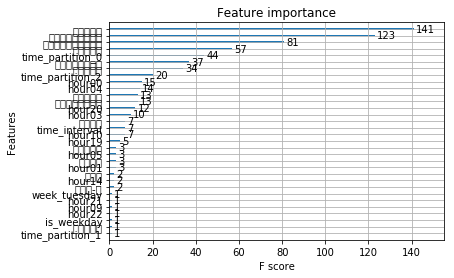

In [60]:
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# XGBoost训练过程
X_train, X_test, y_train, y_test = train_test_split(x_train, y_new_add_amount, test_size=0.2, random_state=0)

# model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True, objective='reg:gamma')
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# 对测试集进行预测
ans = model.predict(X_test)

# 显示重要特征
plot_importance(model)
plt.show() 

In [61]:
from sklearn import metrics
print("MSE:",metrics.mean_squared_error(y_test, ans))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, ans))) 

MSE: 3432262.749649172
RMSE: 1852.6367020139626


MSE: 1410750.7644944387
RMSE: 1187.7502955143555


Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f921cc2eba8>>
Traceback (most recent call last):
  File "/home/wujiaocan/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
/home/wujiaocan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


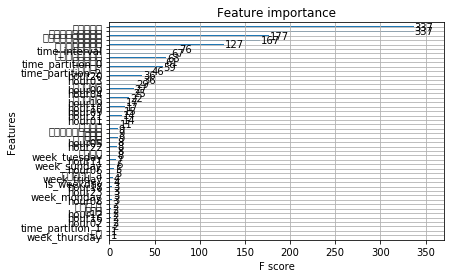

In [73]:
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

# XGBoost训练过程
X_train, X_test, y_train, y_test = train_test_split(x_train, y_new_add_amount, test_size=0.2, random_state=1)

model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=150, silent=True, min_child_weight=3)
# # model_1 = xgb.XGBRegressor()
model.fit(X_train, y_train)

# # 对测试集进行预测
ans = model.predict(X_test)

# # 显示误差

print("MSE:",metrics.mean_squared_error(y_test, ans))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, ans))) 

# # 显示重要特征
plot_importance(model)
plt.show() 

In [96]:
original_df['当前小时新增评分人数']  = original_df['当前小时新增评分人数'].fillna(0)

In [83]:
original_df['当前小时新增弹幕数'] = original_df['当前小时新增弹幕数'].fillna(0)

In [117]:
?xgb.XGBRegressor

MSE: 1284947.4692702414
RMSE: 1133.555234327045


/home/wujiaocan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


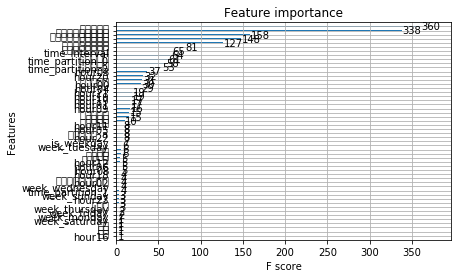

In [103]:
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

# XGBoost训练过程
X_train, X_test, y_train, y_test = train_test_split(x_train, y_new_add_amount, test_size=0.2, random_state=1)

model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=150, silent=True, min_child_weight=3)
# # model_1 = xgb.XGBRegressor()
model.fit(X_train, y_train)

# # 对测试集进行预测
ans = model.predict(X_test)

# # 显示误差

print("MSE:",metrics.mean_squared_error(y_test, ans))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, ans))) 

# # 显示重要特征
plot_importance(model)
plt.show() 

In [111]:
from sklearn import preprocessing
time_interval_scaled = preprocessing.scale(x_train['time_interval'])

/home/wujiaocan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [115]:
# original_df.iloc[1:5,40:60]

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from random import shuffle
# from xgboost.sklearn import XGBClassifier
from sklearn.cross_validation import cross_val_score
import pickle
import time
from hyperopt import fmin, tpe, hp,space_eval,rand,Trials,partial,STATUS_OK

# def loadFile(fileName = "E://zalei//browsetop200Pca.csv"):
#     data = pd.read_csv(fileName,header=None)
#     data = data.values
#     return data

# data = loadFile()
# label = data[:,-1]
# attrs = data[:,:-1]
# labels = label.reshape((1,-1))
# label = labels.tolist()[0]

# minmaxscaler = MinMaxScaler()
# attrs = minmaxscaler.fit_transform(attrs)

# index = range(0,len(y_new_add_amount))
# shuffle(index)

# trainIndex = index[:int(len(y_new_add_amount)*0.7)]
# print(len(trainIndex))
# testIndex = index[int(len(lay_new_add_amountbel)*0.7):]
# print(len(testIndex))

# attr_train = x_train[trainIndex,:]
# print(attr_train.shape)
# attr_test = x_train[testIndex,:]
# print(attr_test.shape)

# label_train = y_new_add_amount[:,trainIndex].tolist()[0]
# print(len(label_train))
# label_test = y_new_add_amount[:,testIndex].tolist()[0]
# print(len(label_test))
# print(np.mat(label_train).reshape((-1,1)).shape)

X_train, X_test, y_train, y_test = train_test_split(x_train, y_new_add_amount, test_size=0.2, random_state=1)

def GBM(argsDict):
    max_depth = argsDict["max_depth"] + 5
    n_estimators = argsDict['n_estimators'] * 5 + 50
    learning_rate = argsDict["learning_rate"] * 0.02 + 0.05
    subsample = argsDict["subsample"] * 0.1 + 0.7
    min_child_weight = argsDict["min_child_weight"]+1
    print("max_depth:" + str(max_depth))
    print("n_estimator:" + str(n_estimators)) 
    print("learning_rate:" + str(learning_rate)) 
    print("subsample:" + str(subsample)) 
    print("min_child_weight:" + str(min_child_weight)) 
    global attr_train,label_train

    gbm = xgb.XGBClassifier(nthread=4,    #进程数
                            max_depth=max_depth,  #最大深度
                            n_estimators=n_estimators,   #树的数量
                            learning_rate=learning_rate, #学习率
                            subsample=subsample,      #采样数
                            min_child_weight=min_child_weight,   #孩子数
                            max_delta_step = 10,  #10步不降则停止
                            objective="reg:linear")

    metric = cross_val_score(gbm, X_train,y_train,cv=5,scoring="roc_auc").mean()
    print("metric:", metric)
    return -metric

space = {"max_depth":hp.randint("max_depth",15),
#          "n_estimators":hp.randint("n_estimators",10),  #[0,1,2,3,4,5] -> [50,]
#          "learning_rate":hp.randint("learning_rate",6),  #[0,1,2,3,4,5] -> 0.05,0.06
#          "subsample":hp.randint("subsample",4),#[0,1,2,3] -> [0.7,0.8,0.9,1.0]
#          "min_child_weight":hp.randint("min_child_weight",5), #
        }
algo = partial(tpe.suggest,n_startup_jobs=1)
best = fmin(GBM,space,algo=algo,max_evals=4)

print("best:",best)
print("GBM(best)", GBM(best))

max_depth:10
n_estimator:95
learning_rate:0.07
subsample:0.8999999999999999
min_child_weight:5


/home/wujiaocan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


In [106]:
# from sklearn.grid_search import GridSearchCV

# X_train, X_test, y_train, y_test = train_test_split(x_train, y_new_add_amount, test_size=0.1, random_state=2)

# cv_params = {'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800]}
# other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 1, 'seed': 0,
#                 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

# model = xgb.XGBRegressor(**other_params)
# optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
# optimized_GBM.fit(X_train, y_train)
# evalute_result = optimized_GBM.grid_scores_
# print('每轮迭代运行结果:{0}'.format(evalute_result))
# print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
# print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

In [3]:
import pandas as pd
original_df = pd.read_csv("./original_df.csv")

In [4]:
del original_df['Unnamed: 0']

In [5]:
def MaxMinNormalization(x):
    x = (x - 0) / (6304 - 0);
    return x

In [6]:
original_df['当前热度值'] = original_df['当前热度值'].apply(MaxMinNormalization)

In [7]:
X = original_df

In [11]:
df = pd.read_csv("./data/filter_time_data.txt", sep='\t\t', header=None)

/home/wujiaocan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [12]:
df.columns = [ '电影ID','时间', '当前热度值', '新增热度值','当前点击量','新增点击量','当前评论数','新增评论数','当前点赞数','新增点赞数',
            '当前踩数','新增踩数','当前评分数','推广位','影片推广位等级','当前小时弹幕数','当前小时新增弹幕数','当前小时评分人数',
            '当前小时新增评分人数','当前小时五星评分人数','当前小时四星评分人数','当前小时三星评分人数','当前小时二星评分人数',
            '当前小时一星评分人数','当日爱奇艺播放指数','影片上线时间','导演','编剧','制片','美术','主演']

In [13]:
y_new_add_amount = df['新增点击量']

In [14]:
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np

#XGBoost训练过程
X_train, X_test, y_train, y_test = train_test_split(X, y_new_add_amount,test_size=0.2, random_state=0)

model = xgb.XGBRegressor(max_depth=8, n_estimators=500, gamma=0.169, colsample_bytree=0.5)
# model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# # 对测试集进行预测
ans = model.predict(X_test)

# # 显示误差
print("MSE:",metrics.mean_squared_error(y_test, ans))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, ans))) 

MSE: 2160386.9621943617
RMSE: 1469.8254869862483


In [30]:
X.columns

Index(['当前热度值', '新增热度值', '当前评论数', '新增评论数', '当前点赞数', '新增点赞数', '当前踩数', '新增踩数',
       '当前评分数', '当前小时新增弹幕数', '当前小时评分人数', '当前小时新增评分人数', '当日爱奇艺播放指数',
       'time_interval', '巴晨旭', '郭靖', '潘文杰', '朱锐斌', '唐顺风', '干志文', '薛少', '褚会林',
       '诸佳倩', '胡正兵', '张伟', '刘洋', '张浩', '李伟', '王伟', '张磊', '冯芷墨', '张涛',
       'is_weekday', '推广位-VIP', '推广位-无', '推广位-网大', '热度值新增百分比', 'week_monday',
       'week_tuesday', 'week_wednesday', 'week_thursday', 'week_friday',
       'week_saturday', 'week_sunday', '推广位等级_a', '推广位等级_b', '推广位等级_c',
       'time_partition_0', 'time_partition_1', 'time_partition_2', 'hour00',
       'hour01', 'hour02', 'hour03', 'hour04', 'hour05', 'hour06', 'hour07',
       'hour08', 'hour09', 'hour10', 'hour11', 'hour12', 'hour13', 'hour14',
       'hour15', 'hour16', 'hour17', 'hour18', 'hour19', 'hour20', 'hour21',
       'hour22', 'hour23'],
      dtype='object')

In [24]:
pd.concat(X_test,y_test,ans,axis=1)

TypeError: concat() got multiple values for argument 'axis'

In [26]:
y_test.to_excel("./test_data2.xlsx")

In [28]:
pd.DataFrame(ans).to_excel("./test_data4.xlsx")

In [29]:
X_test.to_excel("./test_data3.xlsx")